In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
stocks = ["AAPL", "AMD", "AMZN", "MSFT", "NVDA"]

dataFrames = []
unscaledDataFrames = []
scalers = []

for stock in stocks :
  data_set = pd.read_csv(stock + ".csv")
  df = data_set[[ "open", "high", "low", "close",
         "volume", "trade_count"]]
  unscaledDataFrames.append(df)
  sc = MinMaxScaler(feature_range = (0, 1))
  df = sc.fit_transform(df)
  scalers.append(sc)
  dataFrames.append(df)




In [3]:
window_size = 50
data = dataFrames[0]
rawData = []

X_train, y_train, X_valid, y_valid, X_test, y_test = [], [], [], [], [], []

for i in range(len(stocks)) :
  data = dataFrames[i]
  unscaledData = unscaledDataFrames[i]

  X = []
  X_unScaled = []
# Create input-output pairs
  for i in range(len(data) - window_size):
    X.append(data[i:i+window_size])
    X_unScaled.append(unscaledData[i:i+window_size])

  X_unScaled = np.array(X_unScaled)
  rawData.append(X_unScaled)
  X = np.array(X)


  current_X_train, current_y_train = X[:int(len(data)*0.7), :window_size], X[:int(len(data)*0.7), 4]
  current_X_valid, current_y_valid = X[int(len(data)*0.7):int(len(data)*0.9), :window_size], X[int(len(data)*0.7):int(len(data)*0.9), 4]
  current_X_test, current_y_test = X[int(len(data)*0.9):, :window_size], X[int(len(data)*0.9):, 4]

  X_train.append(current_X_train)
  X_valid.append(current_X_valid)
  X_test.append(current_X_test)

  y_train.append(current_y_train)
  y_valid.append(current_y_valid)
  y_test.append(current_y_test)

print(rawData[0].shape)


(1255, 50, 6)


In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True, title="series"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(window_size, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(window_size, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.title(title)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [5]:
def plot_learning_curves(loss, val_loss, title):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(45, return_sequences=True, input_shape=[None, 6]),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(45, return_sequences=True),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(45, return_sequences=False),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(6)
])

model.compile(loss="mse", optimizer="adam")

stocks = ["aapl", "amd", "amzn", "msft", "nvda"]
histories = []

for i in range(len(stocks)):
  histories.append(model.fit(X_train[i], y_train[i], epochs = 50, batch_size = 32,
                    validation_data=(X_valid[i], y_valid[i])))
  model.save(stocks[i] + "_lstm_model.h5")



In [7]:
for i in range(len(stocks)):
  print("Evaluation for " + stocks[i])
  model.evaluate(X_valid[i], y_valid[i])

Evaluation for aapl
9/9 [==============================] - 0s 11ms/step - loss: 0.0019
Evaluation for amd
9/9 [==============================] - 0s 12ms/step - loss: 0.0033
Evaluation for amzn
9/9 [==============================] - 0s 12ms/step - loss: 0.0080
Evaluation for msft
9/9 [==============================] - 0s 11ms/step - loss: 0.0078
Evaluation for nvda
9/9 [==============================] - 0s 12ms/step - loss: 0.0024


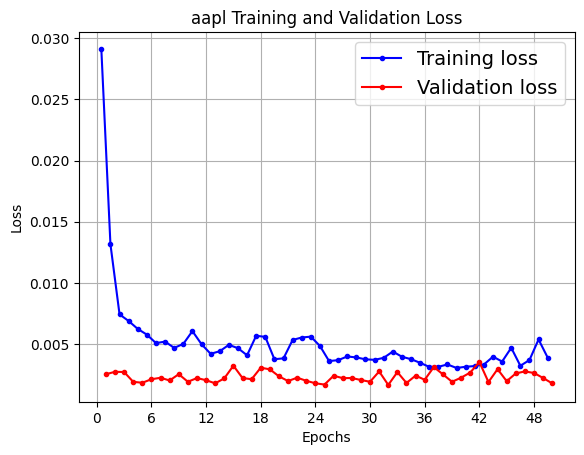

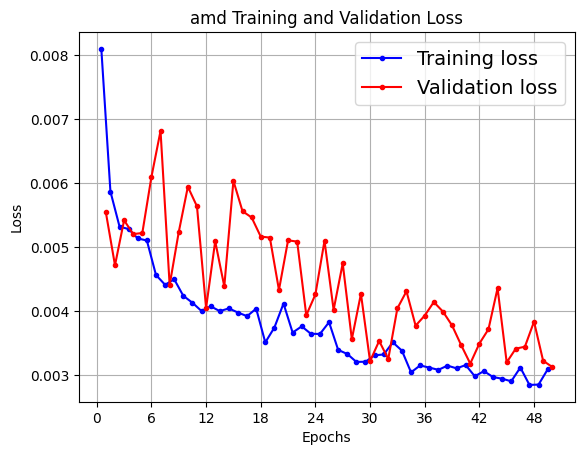

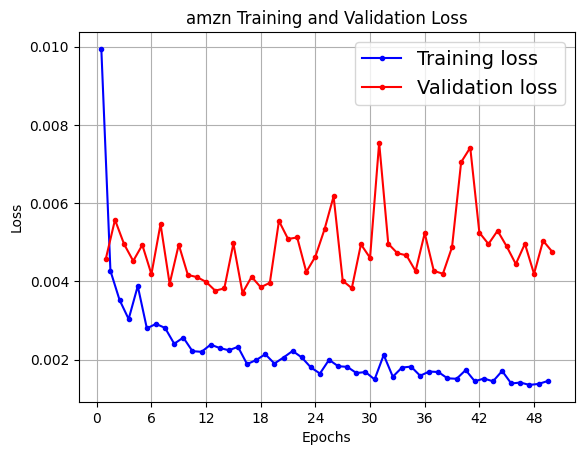

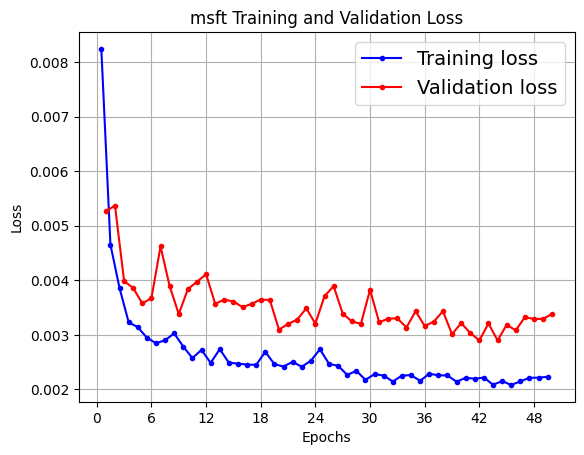

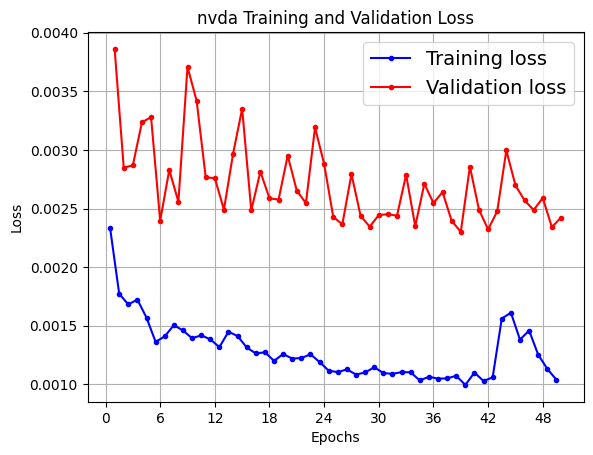

<Figure size 640x480 with 0 Axes>

In [8]:
for i in range(len(stocks)):
  plot_learning_curves(histories[i].history["loss"], histories[i].history["val_loss"],
                       stocks[i] + " Training and Validation Loss")
  plt.show()
  plt.savefig(stocks[i] + ' loss.png')


(261, 50, 6)
(50, 6)
(1, 50, 6)
1/1 [==============================] - 0s 18ms/step
[[0.07257996 0.06705038 0.0742279  0.07141912 0.28348923 0.17392817]]


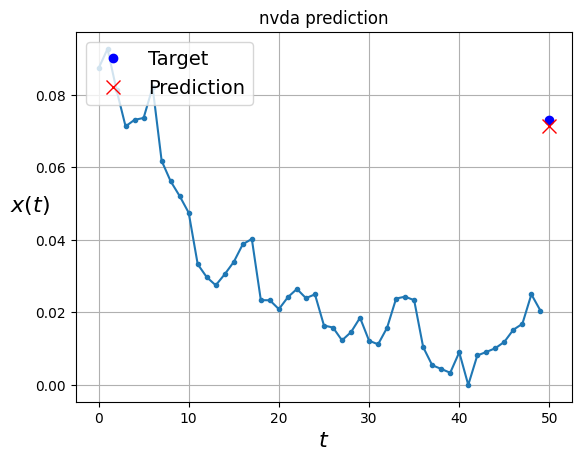

In [17]:
print(X_valid[i].shape)
test = X_valid[i][0]
print(test.shape)
reshaped_arr = test.reshape(1, 50, 6)
print(reshaped_arr.shape)
testPred = model.predict(reshaped_arr)
print(testPred)
plot_series(X_valid[i][0, :, 3], y_valid[i][0, 3], testPred[0, 3], title=stocks[i] + " prediction")

9/9 [==============================] - 1s 12ms/step


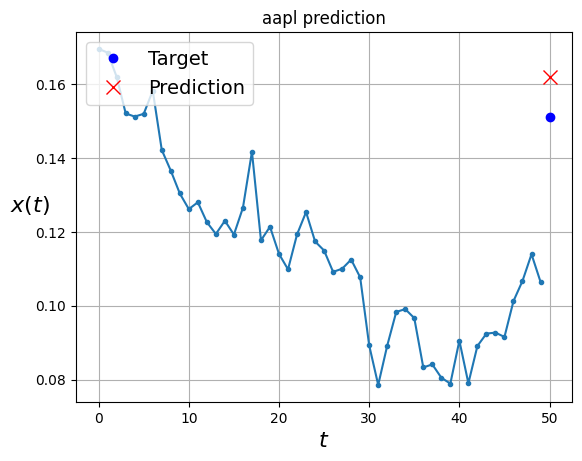

9/9 [==============================] - 0s 12ms/step


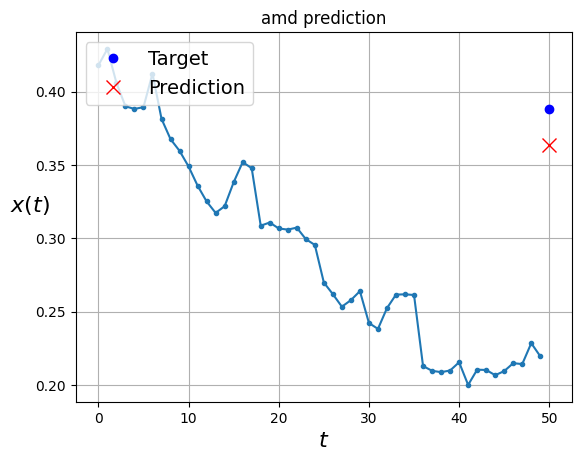

9/9 [==============================] - 0s 11ms/step


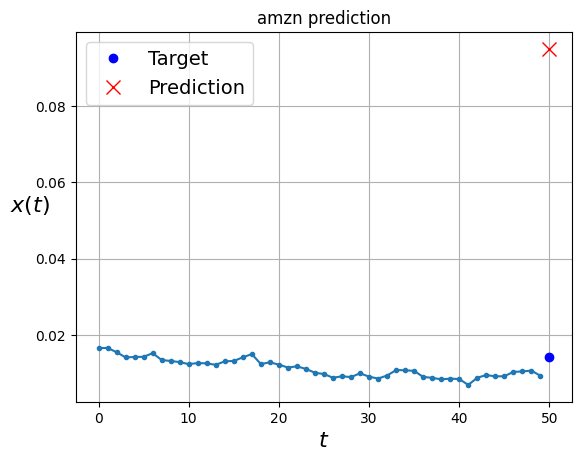

9/9 [==============================] - 0s 11ms/step


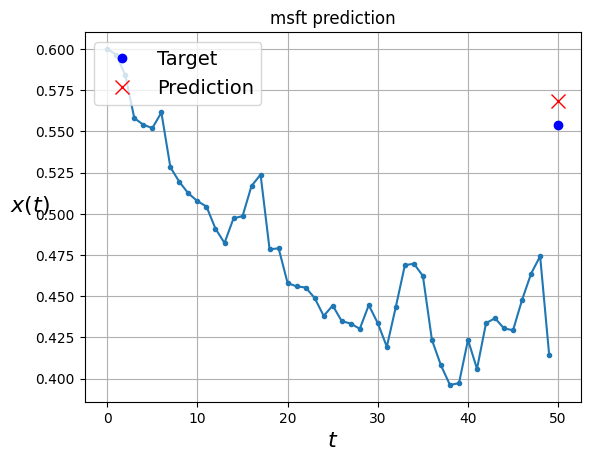

9/9 [==============================] - 0s 12ms/step


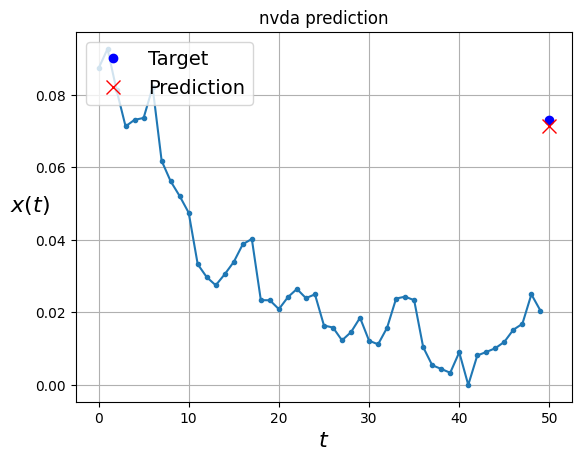

[1.9033200e+02 1.9256931e+02 1.8954819e+02 1.9200774e+02 8.8519312e+07
 5.4190988e+05]
(261, 6)


<Figure size 640x480 with 0 Axes>

In [9]:
y_pred_unscaled = []
y_preds = []

for i in range(len(stocks)) :
  y_pred = model.predict(X_valid[i])
  y_preds.append(y_pred)
  y_pred_unscaled.append(scalers[i].inverse_transform(y_preds[i]))

  plot_series(X_valid[i][0, :, 3], y_valid[i][0, 3], y_pred[0, 3], title=stocks[i] + " prediction")
  plt.show()
  plt.savefig(stocks[i] + '_predict_unscaled.png')

print(y_pred_unscaled[0][-1, :])
print(y_pred_unscaled[0].shape)

In [10]:
print(y_pred_unscaled[0][-1, :])
print(y_pred_unscaled[0].shape)

[1.9033200e+02 1.9256931e+02 1.8954819e+02 1.9200774e+02 8.8519312e+07
 5.4190988e+05]
(261, 6)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
